   Unnamed: 0  Zaman  Maxell     GP  Fujitsu  Duracell
0         NaN    0.0   3.307  3.301    3.287     3.238
1         NaN    0.0   3.307  3.301    3.287     3.238
2         NaN    1.0   3.307  3.301    3.287     3.240
3         NaN    3.0   3.112  3.035    3.091     3.071
4         NaN    5.0   3.066  3.015    3.051     3.039
Unnamed: 0    6370
Zaman          315
Maxell         317
GP             315
Fujitsu          0
Duracell       372
dtype: int64
Number of rows remaining: 6370
Zaman       315
Maxell      317
GP          315
Fujitsu       0
Duracell    372
dtype: int64
Number of rows remaining: (6370, 5)
      Zaman  Maxell     GP  Fujitsu  Duracell
0       0.0   3.307  3.301    3.287     3.238
1       0.0   3.307  3.301    3.287     3.238
2       1.0   3.307  3.301    3.287     3.240
3       3.0   3.112  3.035    3.091     3.071
4       5.0   3.066  3.015    3.051     3.039
...     ...     ...    ...      ...       ...
6365    NaN     NaN    NaN    1.804       NaN
6366    NaN    

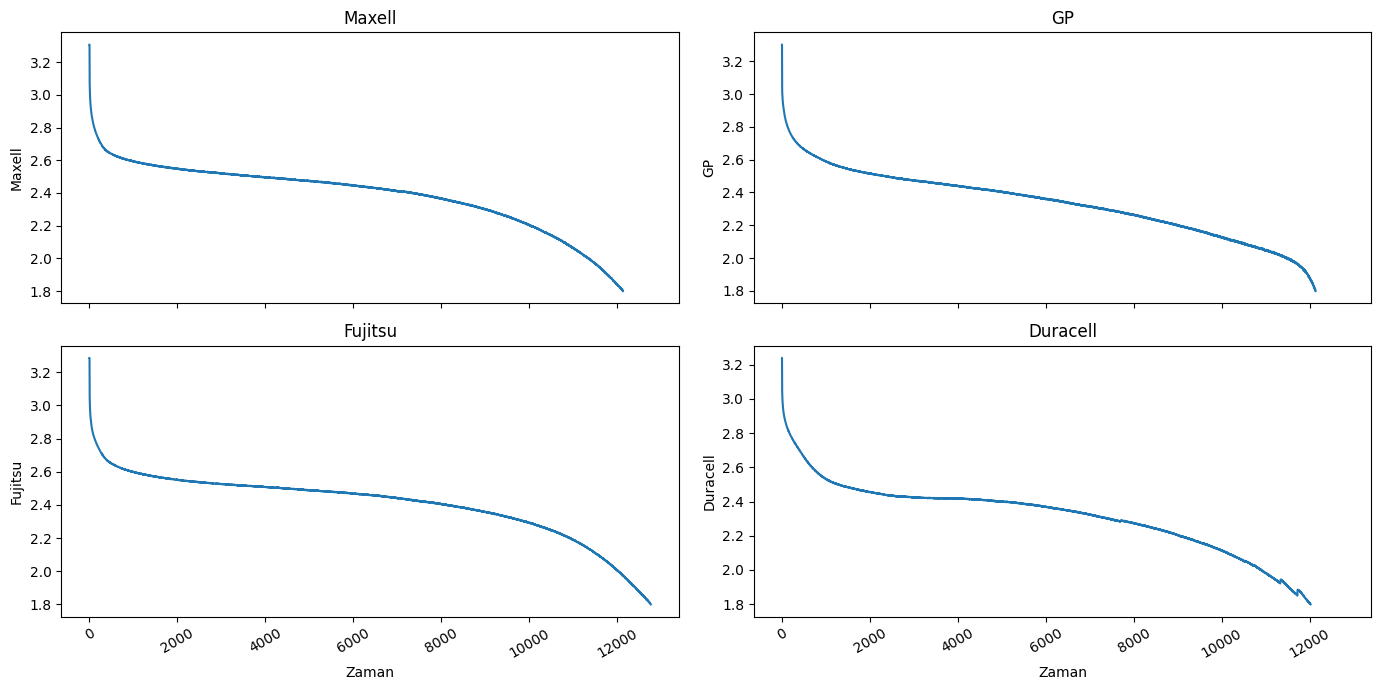

Number of NaN values: 0


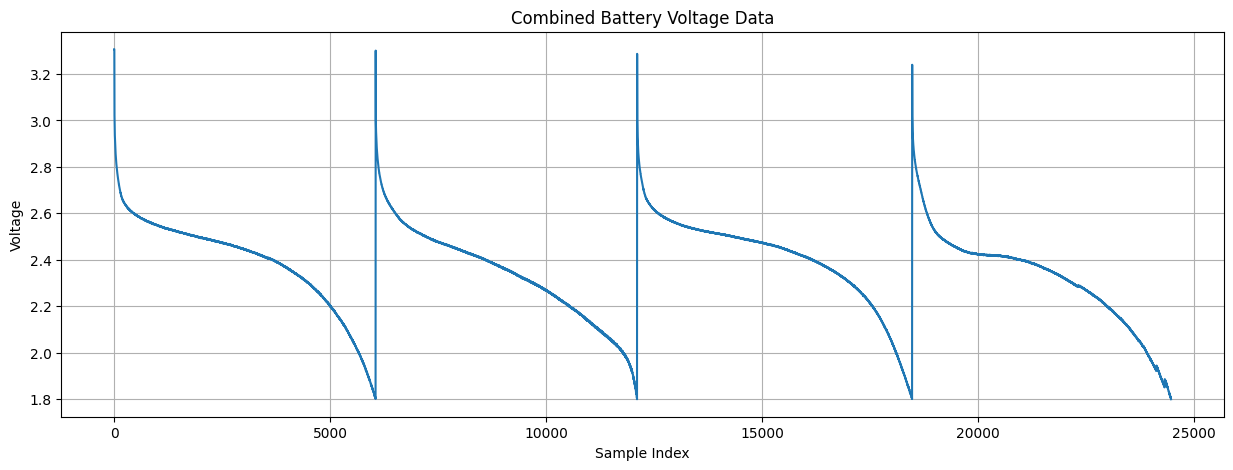

[1.         1.         1.         0.87068966 0.84018568]
[0.32360743 0.32228117 0.32228117 0.32228117 0.32360743]
[0.40384615 0.40318302 0.40384615 0.40450928 0.40384615]


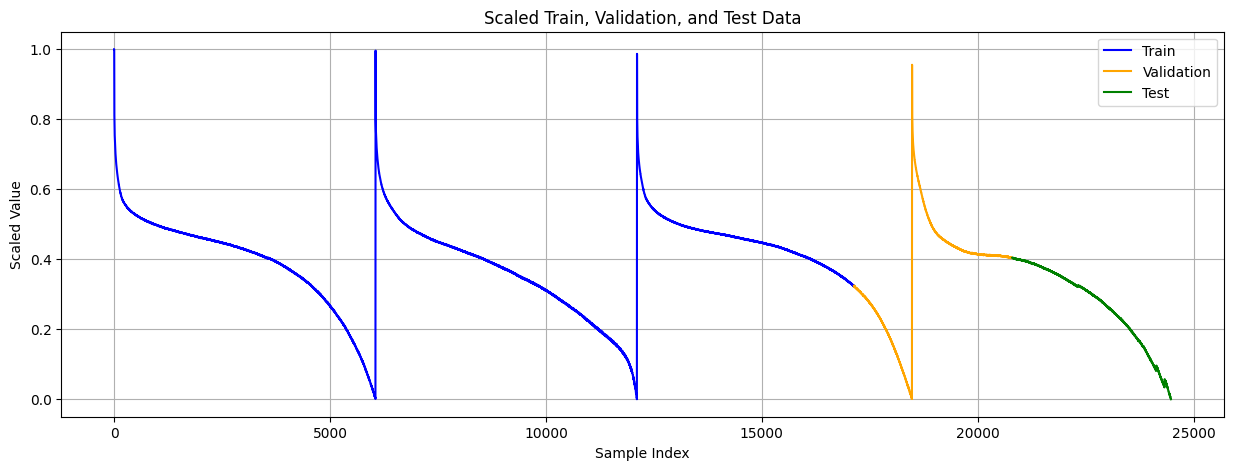

torch.Size([17066, 67]) torch.Size([17066])
torch.Size([3604, 67]) torch.Size([3604])
torch.Size([3605, 67]) torch.Size([3605])
Batch x shape: torch.Size([32, 67])
Batch y shape: torch.Size([32])


In [1]:
%run DatasetUpload.ipynb

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [3]:

PATH = 'Attention_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): Attention(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
       

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): Attention(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
       

In [5]:
def calculate_metrics_sklearn(y_true, y_pred):
    """Calculate R², MAE, MSE, and MAPE using sklearn metrics."""
    # R²
    r2 = r2_score(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    # mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Multiply by 100 to get percentage

    return r2, mae, mse

def Train(model, train_loader, valid_loader, test_loader, args, save_folder=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Ensure the model is on the correct device

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    # Define loss function
    mse_loss = torch.nn.MSELoss()

    min_loss = 10
    stop = 0
    train_losses = []
    valid_losses = []
    best_state = None

    # Store metrics for train, validation, and test
    train_r2_values = []
    valid_r2_values = []

    for e in range(1, args.n_epoch + 1):
        # --------- Train one epoch manually ---------
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(pred.cpu().detach().numpy())
            all_train_labels.append(label.cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Calculate metrics for training
        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
        train_r2, train_mae,train_mse = calculate_metrics_sklearn(all_train_labels, all_train_preds)
        train_r2_values.append(train_r2)

        scheduler.step()

        # --------- Validation manually ---------
        model.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)
                label = label.unsqueeze(1)
                pred = model(data)
                loss = mse_loss(pred, label)
                valid_loss += loss.item()

                all_valid_preds.append(pred.cpu().detach().numpy())
                all_valid_labels.append(label.cpu().detach().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Calculate metrics for validation
        all_valid_preds = np.concatenate(all_valid_preds, axis=0)
        all_valid_labels = np.concatenate(all_valid_labels, axis=0)
        valid_r2, valid_mae, valid_mse = calculate_metrics_sklearn(all_valid_labels, all_valid_preds)
        valid_r2_values.append(valid_r2)

        lr = optimizer.state_dict()['param_groups'][0]['lr']
        
        # Print each epoch's training and validation results
        print(f"Epoch [{e}/{args.n_epoch}] - Train Loss: {train_loss:.5f} | Train R²: {train_r2:.5f} | Train MAE: {train_mae:.5f} | Train MSE: {train_mse:.5f}")
        print(f"             - Valid Loss: {valid_loss:.5f} | Valid R²: {valid_r2:.5f} | Valid MAE: {valid_mae:.5f} | Valid MSE: {valid_mse:.5f}")
    
        
        if e % 10 == 0:
            print()  # Newline every 10 epochs for clarity

        # --------- Save best model ---------
        if valid_loss < min_loss:
            best_state = model.state_dict()
            min_loss = valid_loss
            stop = 0
        else: stop += 1
        # --------- Early stopping ---------
        if stop >= args.early_stop:
            print("\nEarly stopping triggered.")
            break

    # --------- After all epochs, evaluate on test set ---------
    test_loss = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)
            test_loss += loss.item()

            all_test_preds.append(pred.cpu().detach().numpy())
            all_test_labels.append(label.cpu().detach().numpy())

    test_loss /= len(test_loader)

    # Flatten the predictions and labels for metric calculations
    all_test_preds = np.concatenate(all_test_preds, axis=0)
    all_test_labels = np.concatenate(all_test_labels, axis=0)
    
    # Calculate metrics for test set
    test_r2, test_mae, test_mse = calculate_metrics_sklearn(all_test_labels, all_test_preds)

    # Print test results at the end of training
    print(f"Final Test Loss: {test_loss:.5f}, Test R²: {test_r2:.5f}, Test MAE: {test_mae:.5f}, Test MSE: {test_mse:.5f}")

    # --------- Save model ---------
    # if save_folder is not None and best_state is not None:
    #     torch.save(best_state, save_folder + '/best_model.pth')

    return train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds


In [6]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 ,all_test_labels, all_test_preds= Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.00790 | Train R²: 0.48186 | Train MAE: 0.03226 | Train MSE: 0.00791
             - Valid Loss: 0.02348 | Valid R²: 0.00341 | Valid MAE: 0.12906 | Valid MSE: 0.02355
Epoch [2/100] - Train Loss: 0.01039 | Train R²: 0.31788 | Train MAE: 0.04588 | Train MSE: 0.01041
             - Valid Loss: 0.02046 | Valid R²: 0.13175 | Valid MAE: 0.11923 | Valid MSE: 0.02051
Epoch [3/100] - Train Loss: 0.00890 | Train R²: 0.41595 | Train MAE: 0.04249 | Train MSE: 0.00891
             - Valid Loss: 0.01526 | Valid R²: 0.35211 | Valid MAE: 0.10113 | Valid MSE: 0.01531
Epoch [4/100] - Train Loss: 0.00621 | Train R²: 0.59212 | Train MAE: 0.03250 | Train MSE: 0.00622
             - Valid Loss: 0.00895 | Valid R²: 0.62008 | Valid MAE: 0.07320 | Valid MSE: 0.00898
Epoch [5/100] - Train Loss: 0.00383 | Train R²: 0.74861 | Train MAE: 0.02464 | Train MSE: 0.00384
             - Valid Loss: 0.00599 | Valid R²: 0.74587 | Valid MAE: 0.05389 | Valid MSE: 0.00600
Epoch [6/100] - Train Los

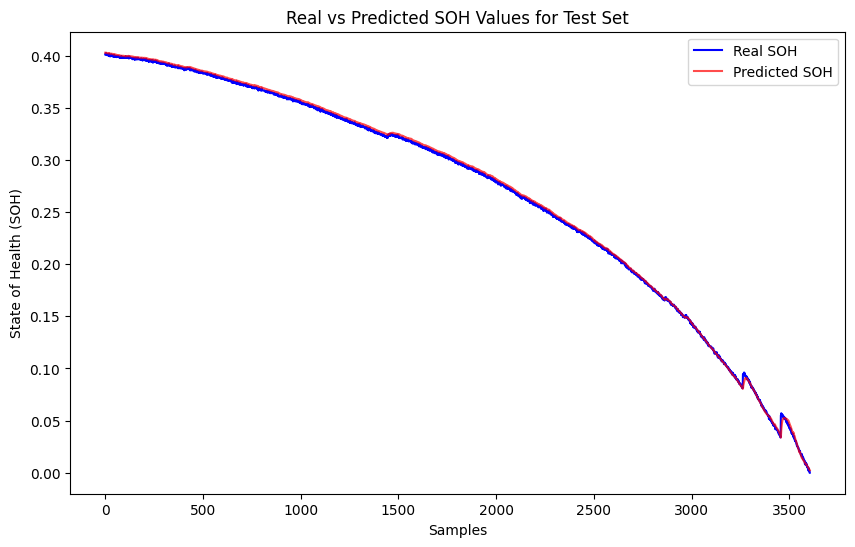

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(all_test_labels, label="Real SOH", color='blue')
plt.plot(all_test_preds, label="Predicted SOH", color='red', alpha=0.7)
plt.title('Real vs Predicted SOH Values for Test Set')
plt.xlabel('Samples')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.show()

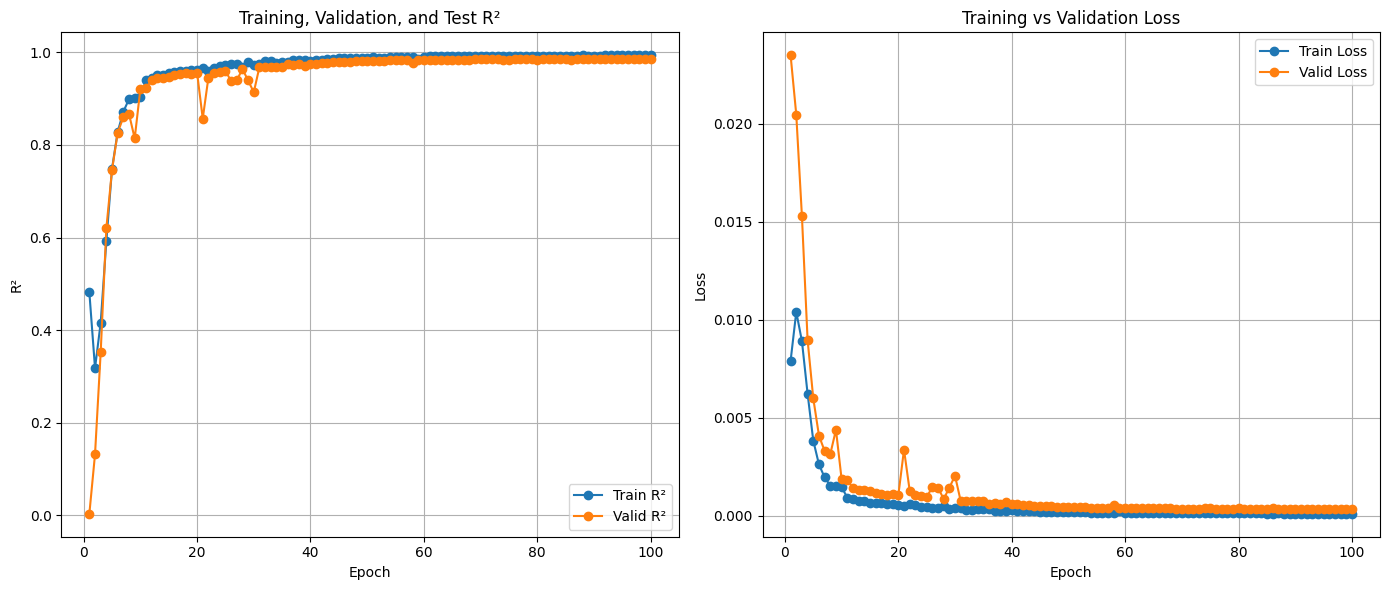

In [9]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:

PATH = 'Attention_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): Attention(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
       

In [11]:
for name, param in model.named_parameters():
        if 'predictor' not in name:  # Don't freeze predictor layers
            param.requires_grad = False
        else:
            param.requires_grad = True  # Keep predictor layers trainab

In [12]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(model, train_loader, val_loader, test_loader, args)

Epoch [1/100] - Train Loss: 0.01112 | Train R²: 0.27031 | Train MAE: 0.04450 | Train MSE: 0.01113
             - Valid Loss: 0.02382 | Valid R²: -0.01117 | Valid MAE: 0.12767 | Valid MSE: 0.02389
Epoch [2/100] - Train Loss: 0.01159 | Train R²: 0.23970 | Train MAE: 0.05376 | Train MSE: 0.01160
             - Valid Loss: 0.02334 | Valid R²: 0.00891 | Valid MAE: 0.12437 | Valid MSE: 0.02342
Epoch [3/100] - Train Loss: 0.01238 | Train R²: 0.18769 | Train MAE: 0.05996 | Train MSE: 0.01239
             - Valid Loss: 0.02309 | Valid R²: 0.01969 | Valid MAE: 0.12366 | Valid MSE: 0.02316
Epoch [4/100] - Train Loss: 0.01228 | Train R²: 0.19400 | Train MAE: 0.05968 | Train MSE: 0.01230
             - Valid Loss: 0.02282 | Valid R²: 0.03117 | Valid MAE: 0.12306 | Valid MSE: 0.02289
Epoch [5/100] - Train Loss: 0.01211 | Train R²: 0.20527 | Train MAE: 0.05893 | Train MSE: 0.01213
             - Valid Loss: 0.02256 | Valid R²: 0.04217 | Valid MAE: 0.12235 | Valid MSE: 0.02263
Epoch [6/100] - Train Lo

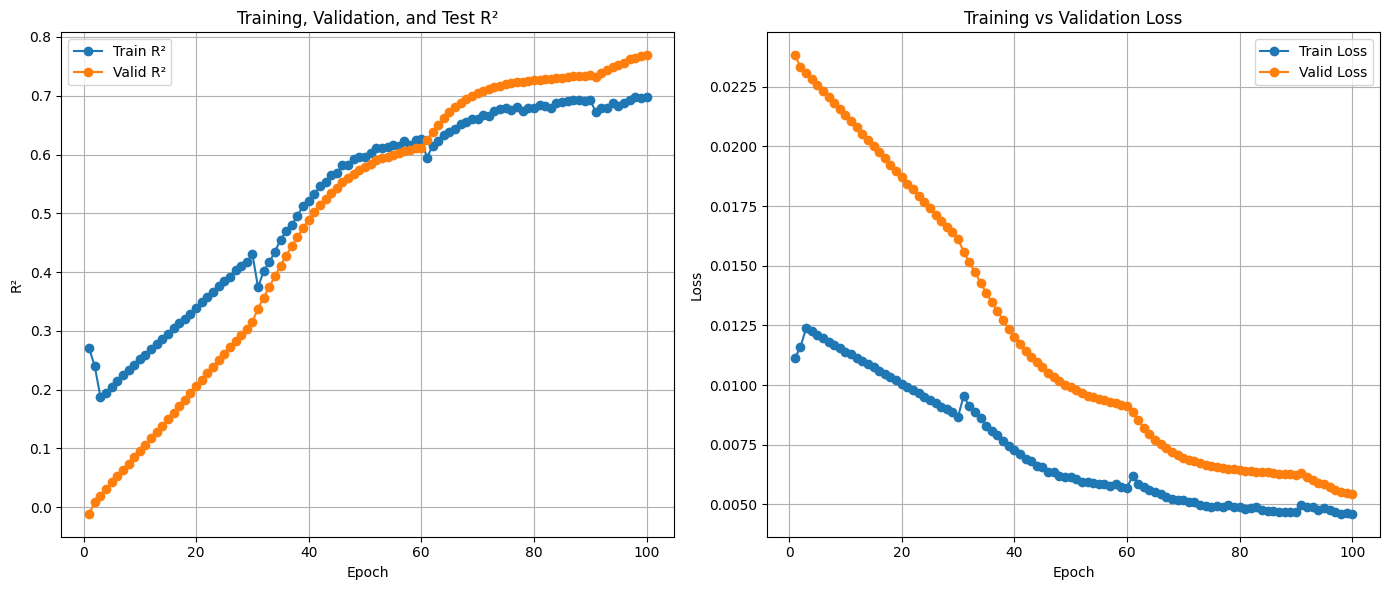

In [13]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


attention works better with freezing its faster and make improving in good way